# Week 7 Solutions

In [1]:
import matplotlib.pyplot as plt
import rebound
import time
import numpy as np
plt.close()


def to_rot_frame(zeta, eta, l):
    x = np.cos(l)*zeta + np.sin(l)*eta
    y = -np.sin(l)*zeta + np.cos(l)*eta
    return np.array([x, y])


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

## Part 1: 3-body simulations & Chaos & Resonance


1. Orbits are sensitive to initial conditions. Now place 2 particles with the same semi-major axis ($a_0 = 0.8$), eccentricity ($e_0 = 0.4$) and longitude of pericentre ($\bar{\omega} = 295^\circ$) but with slightly different initial mean longitudes ($\theta = 293^\circ$ and $\theta = 293.5^\circ$). Run the simulation for 1 period of Jupiter's orbit. Can you see the deviation?

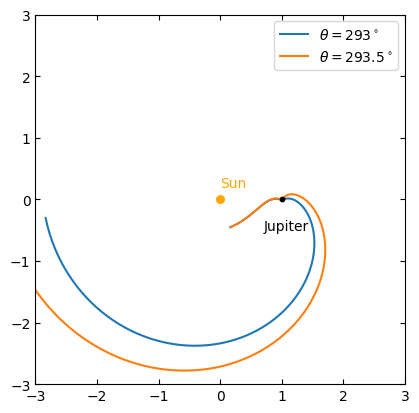

In [2]:
mu2 = 1e-3
mu1 = 1 - mu2

# setup simulations
sim = rebound.Simulation()
sim.add(m = mu1, hash = "star")
sim.add(m = mu2, a = 1, hash = "jupiter")
sim.add(m=0, a=0.8, e=0.4, 
        pomega = 295/180*np.pi, l = 293/180*np.pi,
        hash = "test_1")
sim.add(m=0, a=0.8, e=0.4, 
        pomega = 295/180*np.pi, l = 293.5/180*np.pi,
        hash = "test_2")

sim.move_to_com()
p_orb    = 2*np.pi
num_orb  = 1
Noutputs = 360*num_orb
times    = np.linspace(0, num_orb*2*np.pi, Noutputs)


tp_x = np.zeros((2, Noutputs))
tp_y = np.zeros((2, Noutputs))

ang_p = np.zeros(Noutputs)

for i, t in enumerate(times):
    sim.integrate(t)
    for k in range(2):
        tp_x[k, i] = sim.particles[k+2].x
        tp_y[k, i] = sim.particles[k+2].y
    orb_p = sim.particles["jupiter"].orbit(primary = sim.particles["star"])
    ang_p[i] = orb_p.theta


tp_x[0], tp_y[0] = to_rot_frame(tp_x[0], tp_y[0], ang_p)
tp_x[1], tp_y[1] = to_rot_frame(tp_x[1], tp_y[1], ang_p)


fig, ax = plt.subplots(1, 1)

ax.plot(tp_x[0], tp_y[0], label = r"$\theta = 293^\circ$")
ax.plot(tp_x[1], tp_y[1], label = r"$\theta = 293.5^\circ$")
ax.scatter(-mu2, 0, color = "orange", s=30)
ax.scatter(mu1, 0, color = "black", s=10, zorder= 2)

ax.text(-mu2, 0.2, "Sun", color = "orange")
ax.text(mu1 -0.3, -0.5, "Jupiter",  color = "black")

ax.set_aspect('equal', 'box')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.legend()
plt.show()

In [3]:
mu2 = 1e-3
mu1 = 1 - mu2
C_j = 3.07


# location 1: stable
a01 = 0.6944
e01 = 0.2065
# location 2: chaotic
a02 = 0.6984
e02 = 0.1967
# small deviation for the pair of particles at each loc
devi = 0.00005

a01d, e01d = a01 + devi, e01 + devi
a02d, e02d = a02 + devi, e02 + devi

# or get location a,e with Murray function 9.5
def get_ae_from_x0(x0, devi = 0, Cj = C_j):
    x0  += devi
    y0  = 0 + devi
    print("for the value of x0:", x0)
    r10     = x0 + mu2
    r20     = mu1 - x0
    vx0_rot = 0
    vy0_rot = np.sqrt(x0**2 + y0**2 + 2*(mu1/r10 + mu2/r20) -vx0_rot**2 - Cj)

    vx0     = vx0_rot - y0 
    vy0     = vy0_rot + x0

    V2      = vx0_rot**2 + (vy0_rot + x0 + mu2)**2
    h2      = ((x0 + mu2)*(vy0_rot + x0 + mu2))**2

    a00 = 1/(2/r10 - V2/mu1)
    e00 = np.sqrt(1- h2/(a00*mu1))
    print("you get:", a00, e00)
    return a00, e00, vx0, vy0


x0_pack = [0.55, 0.55001, 0.56, 0.56001]

a01,  e01,  vx01,  vy01  = get_ae_from_x0(x0_pack[0])
a01d, e01d, vx01d, vy01d = get_ae_from_x0(x0_pack[1])
a02,  e02,  vx02,  vy02  = get_ae_from_x0(x0_pack[2])
a02d, e02d, vx02d, vy02d = get_ae_from_x0(x0_pack[3])


# setup simulations
sim = rebound.Simulation()
sim.add(m = mu1, hash = "star")
sim.add(m = mu2, a = 1, hash = "jupiter")
sim.move_to_com()

# sim.add(m=0, a=a01, e=e01, hash = "loc1")
# sim.add(m=0, a=a01d, e=e01d, hash = "loc1_d")
# sim.add(m=0, a=a02, e=e02, hash = "loc2")
# sim.add(m=0, a=a02d, e=e02d, hash = "loc2_d")

sim.add(m=0, x=x0_pack[0], y=0, vx=vx01, vy=vy01, hash = "loc1")
sim.add(m=0, x=x0_pack[1], y=0, vx=vx01d, vy=vy01d, hash = "loc1_d")
sim.add(m=0, x=x0_pack[2], y=0, vx=vx02, vy=vy02, hash = "loc2")
sim.add(m=0, x=x0_pack[3], y=0, vx=vx02d, vy=vy02d, hash = "loc2_d")

p_orb    = 2*np.pi
num_orb  = 300
Noutputs = 360*num_orb
times    = np.linspace(0, num_orb*2*np.pi, Noutputs)


tp_a = np.zeros((4, Noutputs))
tp_e = np.zeros((4, Noutputs))
tp_x = np.zeros((4, Noutputs))
tp_y = np.zeros((4, Noutputs))

tp_vx = np.zeros((4, Noutputs))
tp_vy = np.zeros((4, Noutputs))

ang_p = np.zeros(Noutputs)

for i, t in enumerate(times):
    sim.integrate(t, exact_finish_time=1)

    for k in range(4):
        tp_a[k, i] = sim.orbits()[k+1].a
        tp_e[k, i] = sim.orbits()[k+1].e
        tp_x[k, i] = sim.particles[k+2].x
        tp_y[k, i] = sim.particles[k+2].y
        tp_vx[k, i] = sim.particles[k+2].vx
        tp_vy[k, i] = sim.particles[k+2].vy

    orb_p = sim.particles["jupiter"].orbit(primary = sim.particles["star"])
    ang_p[i] = orb_p.theta


for the value of x0: 0.55
you get: 0.6958479821106044 0.2081603824893759
for the value of x0: 0.55001
you get: 0.6958519812452557 0.2081505624027322
for the value of x0: 0.56
you get: 0.6998055402428616 0.19834873012678703
for the value of x0: 0.56001
you get: 0.6998094554654463 0.19833892551956173


Here above, I have written the function to calculate $a$ and $e$ for a given value of $x_0$, $y_0$, $\dot{x}_0$, and $\dot{y}_0$. We can see that the calculated value is different from what *Murray* calims in Fig. 9.4 and 9.6. 

2. Starting with $x_0 = 0.55$ results in a regular orbit, and $x_0 = 0.56$ in chaotic orbit. It is expected in Fig. 9.4 and 9.6 in *Murray*.

3. As shown in Fig. 9.8, deviation starts around 60 Jupiter orbits.

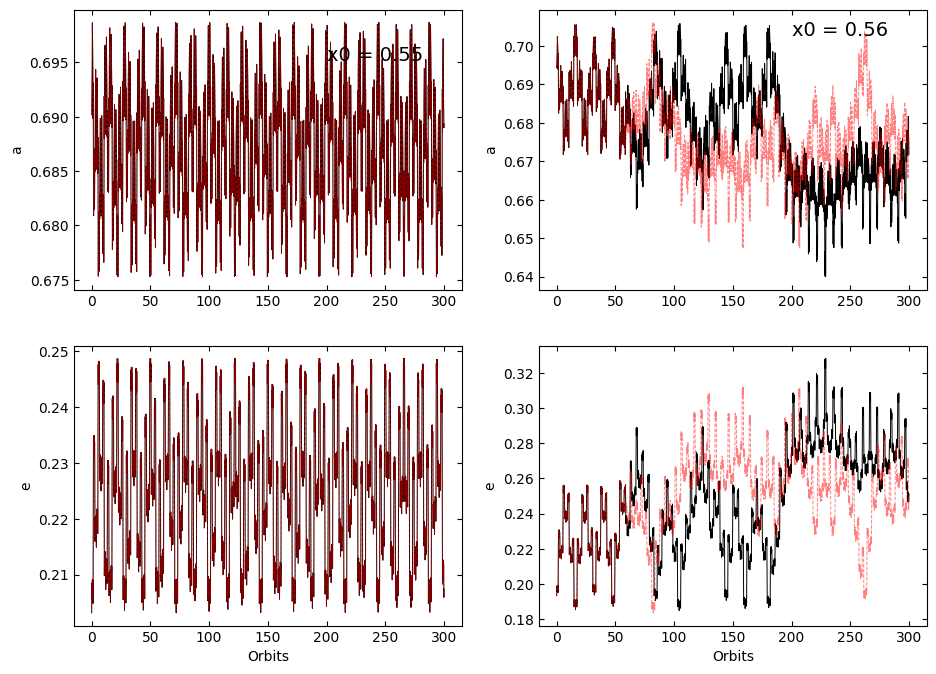

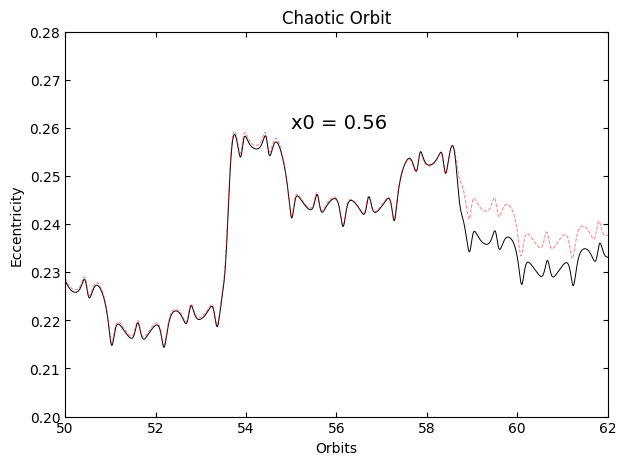

In [4]:
# plot the a,e for 4 particles in 2 different location
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(11, 8))

ax1[0].plot(times / p_orb, tp_a[0], 
         linewidth = 0.7, color = "black", alpha  =1)
ax2[0].plot(times / p_orb, tp_e[0], 
         linewidth = 0.7, color = "black", alpha  =1)
ax1[0].plot(times / p_orb, tp_a[1], 
         linewidth = 0.7, linestyle = "--", color = "red", alpha  =0.5)
ax2[0].plot(times / p_orb, tp_e[1], 
         linewidth = 0.7, linestyle = "--", color = "red", alpha  =0.5)

ax1[0].set_ylabel("a")
ax2[0].set_ylabel("e")
ax2[0].set_xlabel("Orbits")
ax1[1].plot(times / p_orb, tp_a[2], 
         linewidth = 0.7, color = "black", alpha  =1)
ax2[1].plot(times / p_orb, tp_e[2], 
         linewidth = 0.7, color = "black", alpha  =1)

ax1[1].plot(times / p_orb, tp_a[3], 
         linewidth = 0.7, linestyle = "--", color = "red", alpha  =0.5)
ax2[1].plot(times / p_orb, tp_e[3], 
         linewidth = 0.7, linestyle = "--", color = "red", alpha  =0.5)

ax1[1].set_ylabel("a")
ax2[1].set_ylabel("e")
ax2[1].set_xlabel("Orbits")
ax1[0].text(200, 0.995*np.max([tp_a[0], tp_a[1]]), f"x0 = {x0_pack[0]}", fontsize =14)
ax1[1].text(200, 0.995*np.max([tp_a[2], tp_a[3]]), f"x0 = {x0_pack[2]}", fontsize =14)
plt.show()



# to show the divergence of orbit in the second one
fig01, ax3 = plt.subplots(1, 1, figsize=(7, 5))
ax3.set_title("Chaotic Orbit")
ax3.plot(times / p_orb, tp_e[2], 
         linewidth = 0.7, color = "black", alpha  =1)
ax3.plot(times / p_orb, tp_e[3], 
         linewidth = 0.7, linestyle = "--", color = "red", alpha  =0.5)
ax3.set_ylabel("Eccentricity")
ax3.set_xlabel("Orbits")
ax3.set_ylim(0.2, 0.28)
ax3.set_xlim(50, 62)
ax3.text(55, 0.26, f"x0 = {x0_pack[2]}", fontsize =14)
plt.show()

5. We can see three "islands" in the plot for regular orbits. This is because the orbit is close to the 4:7 resonance orbit with Jupiter.

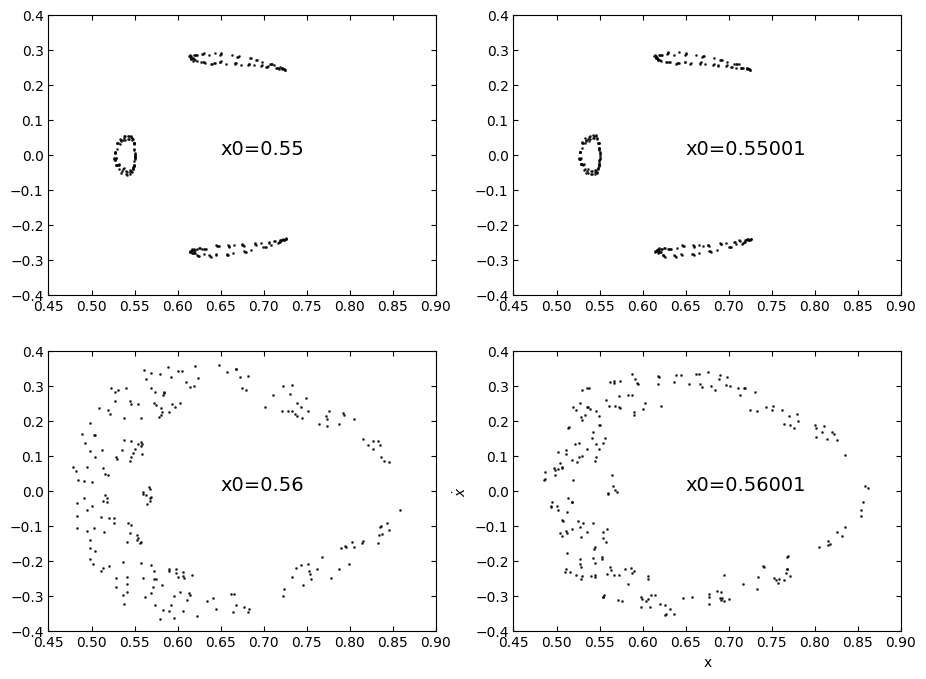

In [5]:
tp_x_rot = np.zeros((4, Noutputs))
tp_y_rot = np.zeros((4, Noutputs))


fig, ax = plt.subplots(2, 2, figsize=(11, 8))

for i in range(4):
    tp_x_rot[i], tp_y_rot[i] = to_rot_frame(tp_x[i], tp_y[i], ang_p)

    zero_crossings = np.where(np.diff(np.sign(tp_y_rot[i])))[0]

    tp_dxdt = np.gradient(tp_x_rot[i], times)
    tp_dydt = np.gradient(tp_y_rot[i], times)


    dxdt = 0.5*(tp_dxdt[zero_crossings + 1] + tp_dxdt[zero_crossings])
    x    = 0.5*(tp_x_rot[i][zero_crossings + 1] + tp_x_rot[i][zero_crossings])

    ax[i//2][i%2].scatter(x, dxdt, s=1, alpha = 0.7, color = "black")
    ax[i//2][i%2].text(0.65, 0, f"x0={x0_pack[i]}", fontsize = 14)
    ax[i//2][i%2].set_xlim(xmin = 0.45, xmax= 0.9)
    ax[i//2][i%2].set_ylim(ymin = -0.4, ymax= 0.4)


plt.xlabel("x")
plt.ylabel(r"$\dot{x}$")
plt.show()

/tmp/ipykernel_5494/784641199.py:41: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(new_times), np.log(gamma[0][1:]), label = "regular")
/tmp/ipykernel_5494/784641199.py:41: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(new_times), np.log(gamma[0][1:]), label = "regular")
/tmp/ipykernel_5494/784641199.py:42: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(new_times), np.log(gamma[1][1:]), label = "chaotic")
/tmp/ipykernel_5494/784641199.py:42: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(new_times), np.log(gamma[1][1:]), label = "chaotic")


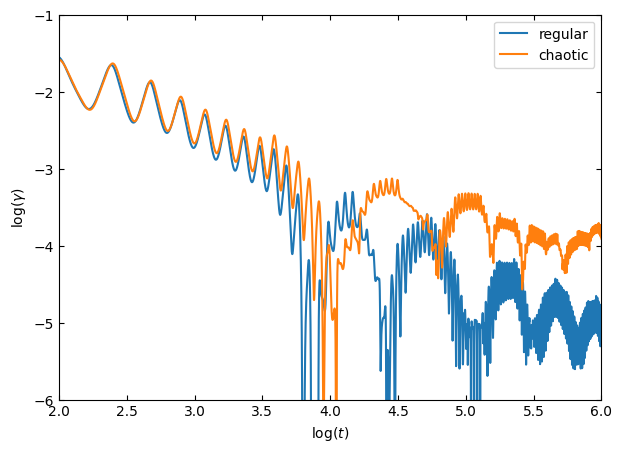

In [26]:
# now we plot the Lyapounov Characteristic: gamma
d0    = 0.00001
di    = np.zeros((2, Noutputs))
gamma = np.zeros((2, Noutputs))

tp_vx_rot =  np.zeros((4, Noutputs))
tp_vy_rot =  np.zeros((4, Noutputs))

def velo_to_rot_frame(zeta, eta, dzeta, deta, l):
    x = np.cos(l)*zeta + np.sin(l)*eta
    y = -np.sin(l)*zeta + np.cos(l)*eta
    xdot = y + np.cos(l)*dzeta + np.sin(l)*deta
    ydot = -x -np.sin(l)*dzeta + np.cos(l)*deta
    return np.array([xdot, ydot])


for j in range(4):
    tp_vx_rot[j], tp_vy_rot[j] = velo_to_rot_frame(tp_x[j], tp_y[j], tp_vx[j], tp_vy[j], ang_p)


di[0] = np.sqrt((tp_x_rot[0] - tp_x_rot[1])**2 + (tp_y_rot[0] - tp_y_rot[1])**2 + 
         (tp_vx_rot[0] - tp_vx_rot[1])**2 + (tp_vy_rot[0] - tp_vy_rot[1])**2)
di[1] = np.sqrt((tp_x_rot[2] - tp_x_rot[3])**2 + (tp_y_rot[2] - tp_y_rot[3])**2 + 
         (tp_vx_rot[2] - tp_vx_rot[3])**2 + (tp_vy_rot[2] - tp_vy_rot[3])**2)


log_did0 = np.log(di[:, 1:]/di[:, :-1])
new_times = times[1:]
# new_times[0] = times[1]

# for j in range(Noutputs):
#     gamma[0][j] = np.sum(log_did0[0][j]) /new_times[j] 
#     gamma[1][j] = np.sum(log_did0[1][j]) /new_times[j]

for j in range(Noutputs-1):
    gamma[0][j+1] = np.sum(log_did0[0][:j]) /new_times[j] 
    gamma[1][j+1] = np.sum(log_did0[1][:j]) /new_times[j]


fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(np.log(new_times), np.log(gamma[0][1:]), label = "regular")
ax.plot(np.log(new_times), np.log(gamma[1][1:]), label = "chaotic")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(xmin=2, xmax = 6)
ax.set_ylim(ymin=-6, ymax = -1)

ax.set_xlabel(r"$\log(t)$")
ax.set_ylabel(r"$\log(\gamma)$")
plt.legend()
plt.show()

6. Now, we can use different orbital resonance ratio to create plot with different numbers of "islands"!

for 8:3 orbit, your a0 is: 0.6299605249474366
for the value of x0: 0.448
you get: 0.6513279775947113 0.31063916268711217


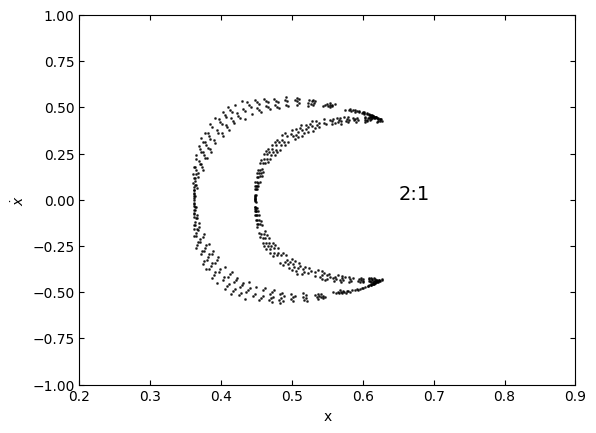

In [31]:
# extra part: can we see different resonance cricles?

# for a given x0, cj, we can run a simulation and plot 
def run_one_plot(x0, CJ, norb=600, 
                 note="unknown", loc = [0,0],
                 plot = True):
    a000,  e000,  vx000,  vy000  = get_ae_from_x0(x0, Cj = CJ)

    # setup simulations
    sim = rebound.Simulation()
    sim.add(m = mu1, hash = "star")
    sim.add(m = mu2, a = 1, hash = "jupiter")

    sim.move_to_com()
    # sim.add(m=0, a=a000, e=e000, hash = "loc1")
    sim.add(m=0, x=x0, y=0, vx=vx000, vy=vy000, hash = "loc1")

    num_orb  = norb
    Noutputs = 180*num_orb
    times    = np.linspace(0, num_orb*2*np.pi, Noutputs)

    tp_x = np.zeros(Noutputs)
    tp_y = np.zeros(Noutputs)

    ang_p = np.zeros(Noutputs)

    for i, t in enumerate(times):
        sim.integrate(t, exact_finish_time=1)
        tp_x[i] = sim.particles[2].x
        tp_y[i] = sim.particles[2].y
        orb_p = sim.particles["jupiter"].orbit(primary = sim.particles["star"])
        ang_p[i] = orb_p.theta

    # change to the rotating frame
    tp_x_rot, tp_y_rot = to_rot_frame(tp_x, tp_y, ang_p)

    zero_crossings = np.where(np.diff(np.sign(tp_y_rot)))[0]

    tp_dxdt = np.gradient(tp_x_rot, times)
    dxdt    = 0.5*(tp_dxdt[zero_crossings + 1] + tp_dxdt[zero_crossings])
    x       = 0.5*(tp_x_rot[zero_crossings + 1] + tp_x_rot[zero_crossings])

    if plot == True:
        plt.scatter(x, dxdt, s=1, alpha = 0.7, color = "black")
        plt.text(loc[0], loc[1],  note, fontsize = 14)
        plt.xlim(xmin = 0.2, xmax= 0.9)
        plt.ylim(ymin = -1, ymax= 1)


        plt.xlabel("x")
        plt.ylabel(r"$\dot{x}$")
        plt.show()

    return x, dxdt



# 2:1 resonance:
a0000 = (1/2)**(2/3)
print("for 8:3 orbit, your a0 is:", a0000)
_, _ = run_one_plot(0.448, 3.07, note="2:1", loc = [0.65, 0])
# run_one_plot(0.518, 3.13, note="2:1", loc = [0.65, 0])


for the value of x0: 0.8
you get: 0.7448072385205545 0.07544604640398452


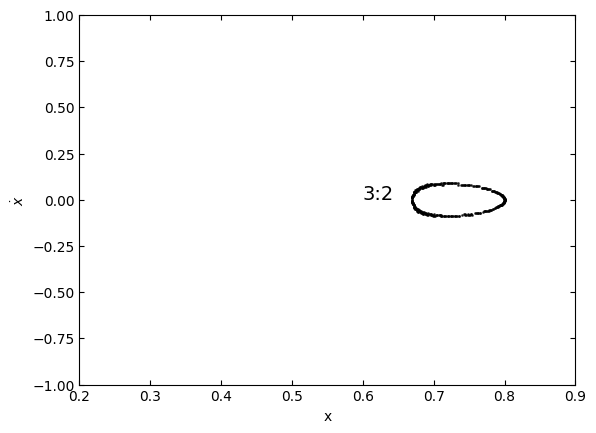

In [ ]:
# 3:2
run_one_plot(0.8, 3.07, note="3:2", loc = [0.6, 0])

for the value of x0: 0.55
you get: 0.6958479821106044 0.2081603824893759


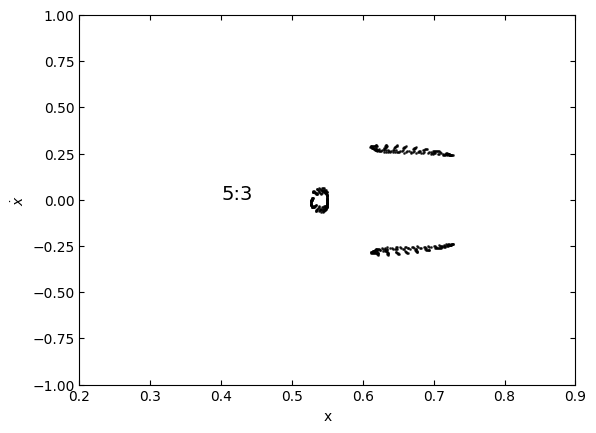

In [ ]:
# 5:3
run_one_plot(0.55, 3.07, note="5:3", loc = [0.4, 0])

for the value of x0: 0.3157
you get: 0.5844553153578788 0.4581279497713602


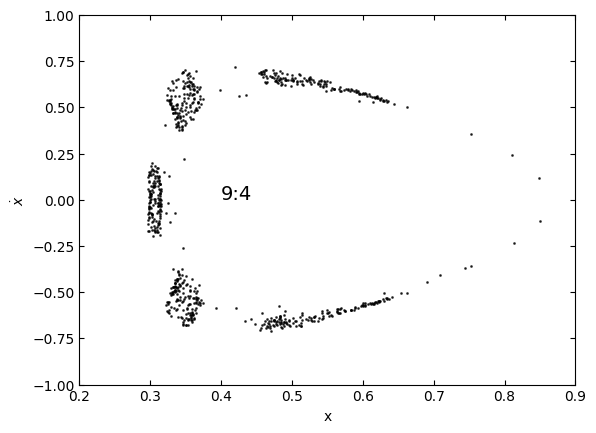

In [ ]:
# 9:4
run_one_plot(0.3157, 3.07, note="9:4", loc = [0.4, 0])

for the value of x0: 0.248
you get: 0.5464277234428195 0.5443130183235361


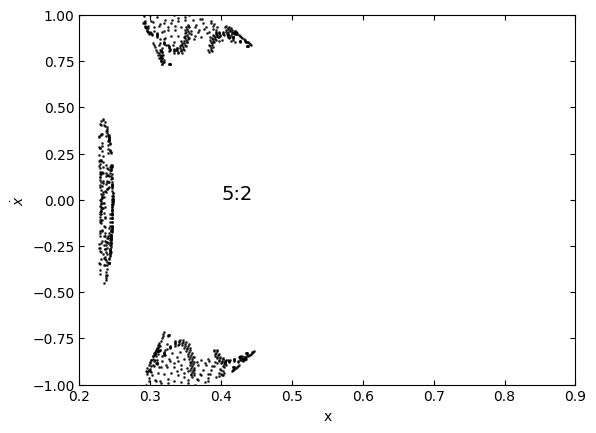

In [ ]:
# 5:2
run_one_plot(0.248, 3.07, note="5:2", loc = [0.4, 0])

for 8:3 orbit, your a0 is: 0.520020955762976
for the value of x0: 0.519020955762976
you get: 0.683083476773796 0.23871536430798249


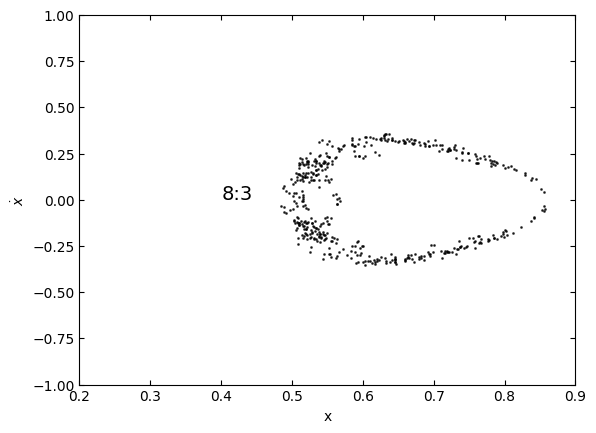

In [ ]:
# 8:3
a0000 = (3/8)**(2/3)
print("for 8:3 orbit, your a0 is:", a0000)
run_one_plot(a0000-mu2, 3.07, note="8:3", loc = [0.4, 0])

7. Now, here is all the resonance all together:

for the value of x0: 0.448
you get: 0.6513279775947113 0.31063916268711217
for the value of x0: 0.8
you get: 0.7448072385205545 0.07544604640398452
for the value of x0: 0.55
you get: 0.6958479821106044 0.2081603824893759
for the value of x0: 0.3157
you get: 0.5844553153578788 0.4581279497713602
for the value of x0: 0.519020955762976
you get: 0.683083476773796 0.23871536430798249
for the value of x0: 0.248
you get: 0.5464277234428195 0.5443130183235361


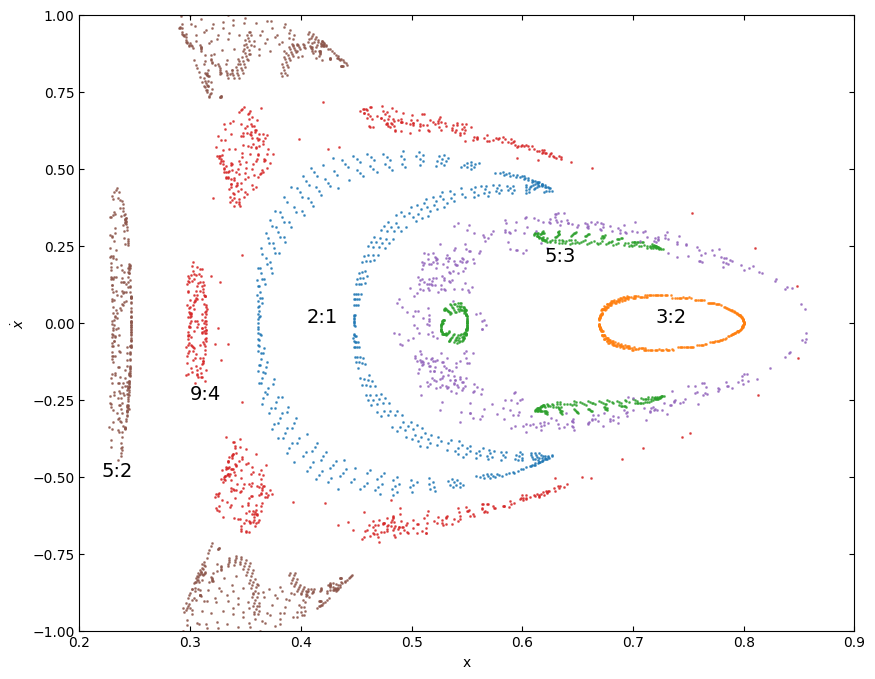

In [35]:
x01, dx01 = run_one_plot(0.448, 3.07, note="2:1", plot = False)
x02, dx02 = run_one_plot(0.8, 3.07, note="3:2", plot = False)
x03, dx03 = run_one_plot(0.55, 3.07, note="5:3", plot = False)
x04, dx04 = run_one_plot(0.3157, 3.07, note="9:4", plot = False)
x05, dx05 = run_one_plot((3/8)**(2/3)-mu2, 3.07, note="8:3", plot = False)
x06, dx06 = run_one_plot(0.248, 3.07, note="5:2", plot = False)


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(x01, dx01, s=1, alpha = 0.7)
ax.scatter(x02, dx02, s=1, alpha = 0.7)
ax.scatter(x03, dx03, s=1, alpha = 0.7)
ax.scatter(x04, dx04, s=1, alpha = 0.7)
ax.scatter(x05, dx05, s=1, alpha = 0.7)
ax.scatter(x06, dx06, s=1, alpha = 0.7)

ax.set_xlim(xmin = 0.2, xmax= 0.9)
ax.set_ylim(ymin = -1, ymax= 1)
ax.set_xlabel("x")

ax.text(0.405, 0, "2:1", color = "black", fontsize = 14)
ax.text(0.3, -0.25, "9:4", color = "black", fontsize = 14)
ax.text(0.72, 0, "3:2", color = "black", fontsize = 14)
ax.text(0.62, 0.2, "5:3", color = "black", fontsize = 14)
ax.text(0.22, -0.5, "5:2", color = "black", fontsize = 14)

ax.set_ylabel(r"$\dot{x}$")
plt.show()
